# Compute Chla fluorescence and bbp from ECO PUK data

I will compute the fluorescence and backscatter from the raw ECO PUK data using the calibration coefficients provided by the manufacturer.

Fluorescence needs to be dark corrected then unquenched and beta will be converted to bbp and separated between baseline and spikes. 


## Import necessary libraries and open dataset

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glidertools as gt

In [2]:
raw = xr.open_dataset("../data/ALR/clean_eco_xr_output.nc")
display(raw)

<xarray.Dataset> Size: 186MB
Dimensions:           (TIME: 844630)
Coordinates:
  * TIME              (TIME) datetime64[ns] 7MB 2024-06-12T00:08:26.395245056...
Data variables: (12/17)
    DEPTH_SCI         (TIME) float64 7MB ...
    DEPTH_ENG         (TIME) float64 7MB ...
    DEPTH_SCI_INTERP  (TIME) float64 7MB ...
    LAT               (TIME) float64 7MB ...
    LON               (TIME) float64 7MB ...
    Temperature       (TIME) float64 7MB ...
    ...                ...
    nav_timestamp     (TIME) float64 7MB ...
    lon               (TIME) float64 7MB ...
    lat               (TIME) float64 7MB ...
    depth             (TIME) float64 7MB ...
    fluo              (TIME) float64 7MB ...
    beta              (TIME) float64 7MB ...
Attributes: (12/14)
    Conventions:          CF-1.9
    title:                ALR profile/transect/other export
    institution:          NOCS
    source:               Polars→xarray export
    history:              Created by export_alr_netcdf()
    author:               hans.hilder@noc.ac.uk
    ...                   ...
    segment_id:           0
    event_type:           x
    group_kind:           other
    group_key:            [0 1]
    surface_threshold_m:  5.0
    event_start_utc:      2024-06-11T23:53:13.455329+00:00

## Compute PSU from conductivity and temperature

In [3]:
import gsw

practical_salinity = gsw.SP_from_C(
    raw["Conductivity"], 
    raw["Temperature"], 
    raw["DEPTH_SCI"]
)

raw = raw.assign(practical_salinity=practical_salinity)

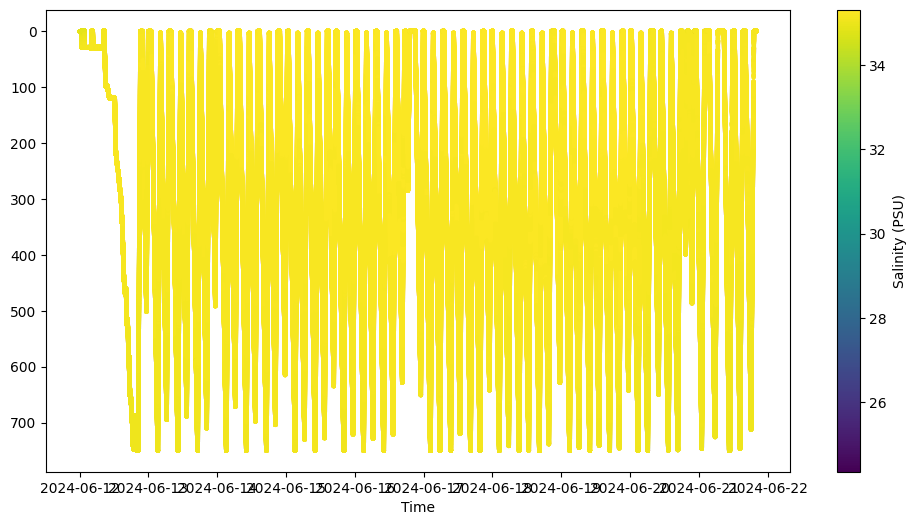

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["practical_salinity"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.colorbar(sc, ax=ax, label="Salinity (PSU)")
ax.set_xlabel("Time")
ax.invert_yaxis()

In [5]:
# Calculate Q1, Q3, and IQR
q1 = raw["practical_salinity"].quantile(0.25)
q3 = raw["practical_salinity"].quantile(0.75)
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter practical_salinity within the bounds
filtered_salinity = raw["practical_salinity"].where(
    (raw["practical_salinity"] >= lower_bound) & (raw["practical_salinity"] <= upper_bound)
)

raw = raw.assign(filtered_practical_salinity=filtered_salinity)

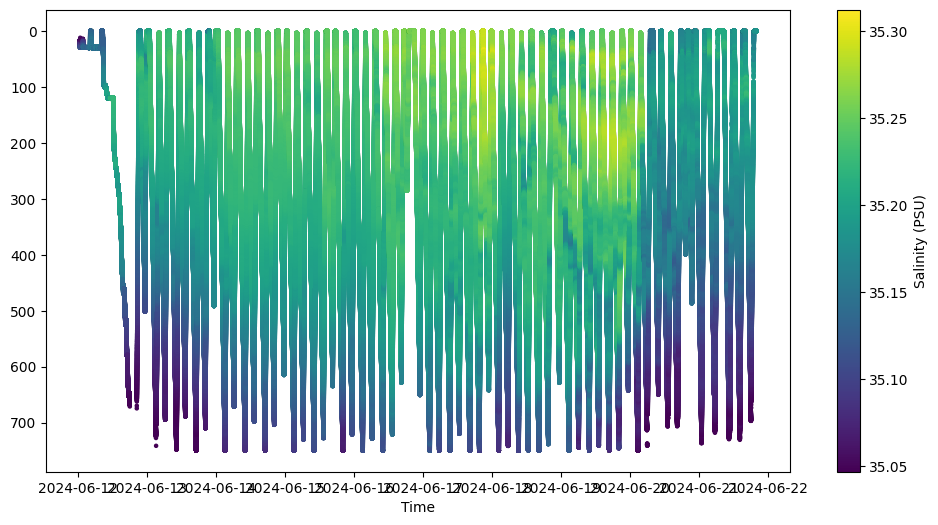

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["filtered_practical_salinity"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.colorbar(sc, ax=ax, label="Salinity (PSU)")
ax.set_xlabel("Time")
ax.invert_yaxis()

## Chla fluorescence

### Use factory calibration to go from counts to mg m-3

Visualisation of raw data

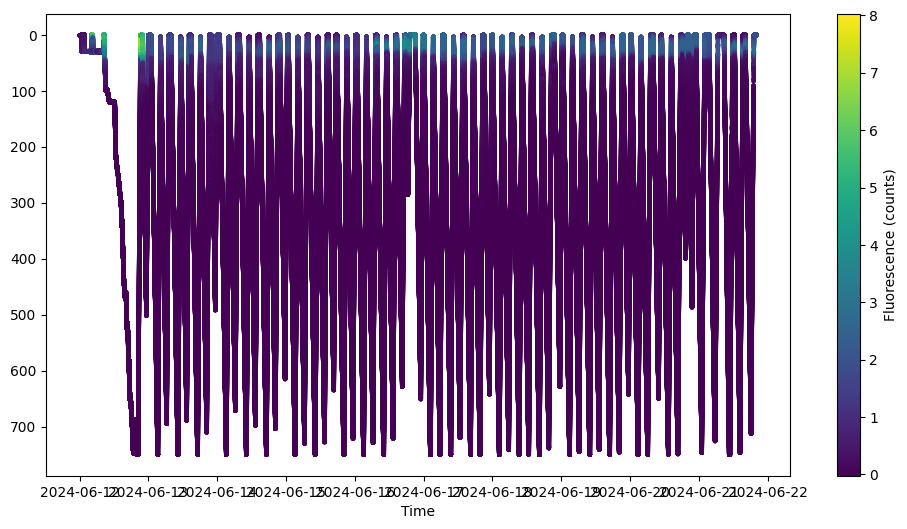

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["fluo"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.colorbar(sc, ax=ax, label="Fluorescence (counts)")
ax.set_xlabel("Time")
ax.invert_yaxis()

Apparently the fluorescence has already been converted to mg m-3. 

## NPQ correction

In [8]:
import math
from sun_position_calculator import SunPositionCalculator

calculator = SunPositionCalculator()

# ----- vectorized wrapper (accepts arrays) -----
def sun_altitude_func(time64, lat, lon):
    # time64, lat, lon are numpy arrays
    unixtime_ms = time64.astype("datetime64[ms]").astype(np.int64)

    # allocate output
    out = np.empty_like(lat, dtype=float)

    # loop at the element level (required because calculator is NOT vectorized)
    it = np.nditer([unixtime_ms, lat, lon, out], 
                   op_flags=[['readonly'], ['readonly'], ['readonly'], ['writeonly']])
    for t, la, lo, o in it:
        pos = calculator.pos(int(t), float(la), float(lo))
        o[...] = math.degrees(pos.altitude)

    return out


# ----- Apply across xarray -----
sun_altitude = xr.apply_ufunc(
    sun_altitude_func,
    raw["TIME"],
    raw["LAT"],
    raw["LON"],
    vectorize=False,          # <- because we vectorized manually inside the function
    dask="parallelized",
    output_dtypes=[float],
)

raw = raw.assign(sun_altitude=sun_altitude)



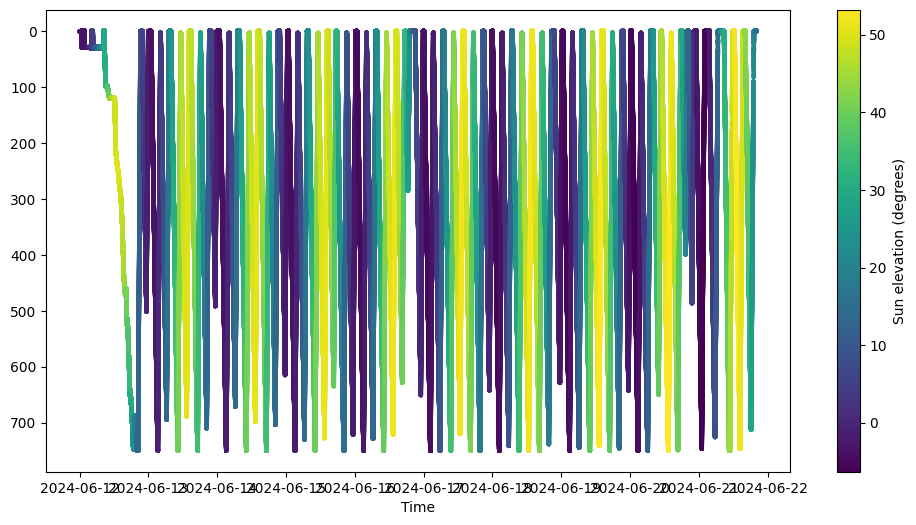

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["sun_altitude"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.colorbar(sc, ax=ax, label="Sun elevation (degrees)")
ax.set_xlabel("Time")
ax.invert_yaxis()

## bbp calculation

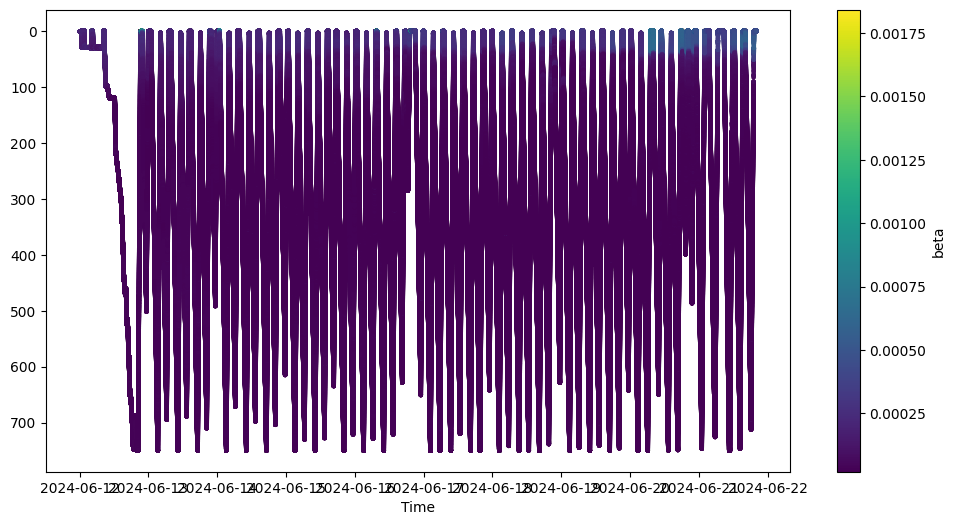

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["beta"].to_numpy(),
    cmap="viridis",
    s=5
)
plt.colorbar(sc, ax=ax, label="beta")
ax.set_xlabel("Time")
ax.invert_yaxis()

In [11]:
theta = 124
xfactor = 1.076
bbp700 = gt.flo_functions.flo_bback_total(raw["beta"], raw['Temperature'], raw["filtered_practical_salinity"], theta, 700, xfactor) 

## Smoothing bbp 700
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp700, 7, spike_method='minmax')

raw = raw.assign(bbp_baseline = bbp_baseline)
raw = raw.assign(bbp700 = bbp700)   



Text(0.5, 1.0, 'bbp_baseline')

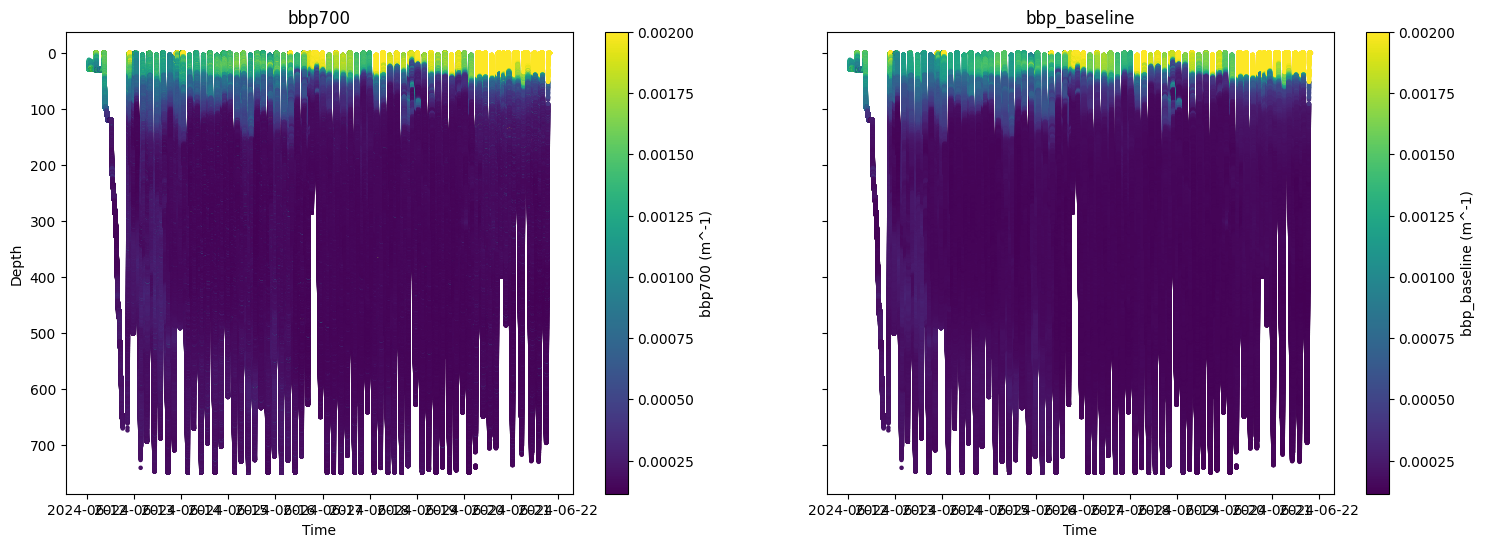

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# First panel: bbp700
sc1 = ax1.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["bbp700"].to_numpy(),
    cmap="viridis",
    s=5,
    rasterized=True,
    vmax=0.002
)
plt.colorbar(sc1, ax=ax1, label="bbp700 (m^-1)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Depth")
ax1.invert_yaxis()
ax1.set_title("bbp700")

# Second panel: bbp_baseline
sc2 = ax2.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["bbp_baseline"].to_numpy(),
    cmap="viridis",
    s=5,
    rasterized=True,
    vmax=0.002
)
plt.colorbar(sc2, ax=ax2, label="bbp_baseline (m^-1)")
ax2.set_xlabel("Time")
ax2.set_title("bbp_baseline")

Text(0.5, 1.0, 'bbp700 Profile (Upcast)')

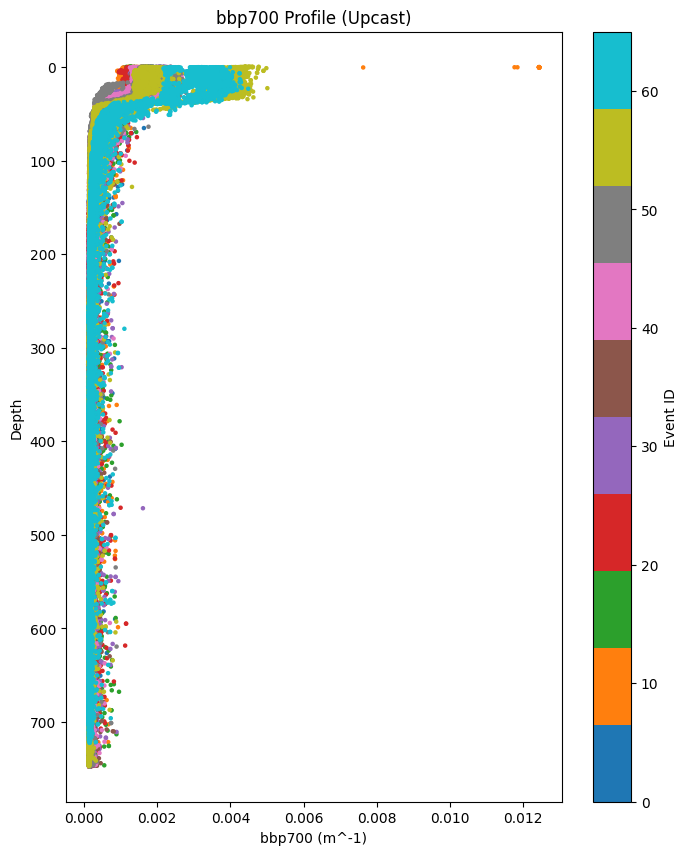

In [17]:
# Filter raw dataset for upcast event_direction
upcast_data = raw.where(raw["event_direction"] == "ascent", drop=True)

# Map event_id to numeric values
event_id_numeric = pd.factorize(upcast_data["event_id"].to_numpy())[0]

# Plot bbp700 profile
fig, ax = plt.subplots(figsize=(8, 10))
sc = ax.scatter(
    upcast_data["bbp700"].to_numpy(),
    upcast_data["depth"].to_numpy(),
    c=event_id_numeric,
    cmap="tab10",
    s=5
)
plt.colorbar(sc, ax=ax, label="Event ID")
ax.set_xlabel("bbp700 (m^-1)")
ax.set_ylabel("Depth")
ax.invert_yaxis()
ax.set_title("bbp700 Profile (Upcast)")

In [18]:
display(upcast_data)

<xarray.Dataset> Size: 37MB
Dimensions:                      (TIME: 200226)
Coordinates:
  * TIME                         (TIME) datetime64[ns] 2MB 2024-06-12T04:15:4...
Data variables: (12/22)
    DEPTH_SCI                    (TIME) float64 2MB 27.39 27.28 ... 1.62 1.69
    DEPTH_ENG                    (TIME) float64 2MB nan nan nan ... nan nan nan
    DEPTH_SCI_INTERP             (TIME) float64 2MB 27.39 27.28 ... 1.62 1.69
    LAT                          (TIME) float64 2MB 63.29 63.29 ... 60.2 60.2
    LON                          (TIME) float64 2MB -20.32 -20.32 ... -20.16
    Temperature                  (TIME) float64 2MB 8.227 8.23 ... 11.05 11.05
    ...                           ...
    beta                         (TIME) float64 2MB 0.000176 ... 0.0004355
    practical_salinity           (TIME) float64 2MB 35.15 35.15 ... 35.16 35.17
    filtered_practical_salinity  (TIME) float64 2MB 35.15 35.15 ... 35.16 35.17
    sun_altitude                 (TIME) float64 2MB 2.974 2.975 ... 21.65 21.65
    bbp_baseline                 (TIME) float64 2MB 0.0011 0.0011 ... 0.002925
    bbp700                       (TIME) float64 2MB 0.001171 ... 0.002925
Attributes: (12/14)
    Conventions:          CF-1.9
    title:                ALR profile/transect/other export
    institution:          NOCS
    source:               Polars→xarray export
    history:              Created by export_alr_netcdf()
    author:               hans.hilder@noc.ac.uk
    ...                   ...
    segment_id:           0
    event_type:           x
    group_kind:           other
    group_key:            [0 1]
    surface_threshold_m:  5.0
    event_start_utc:      2024-06-11T23:53:13.455329+00:00

Text(0.5, 1.0, 'Ascent_8 Profile Depth vs TIME')

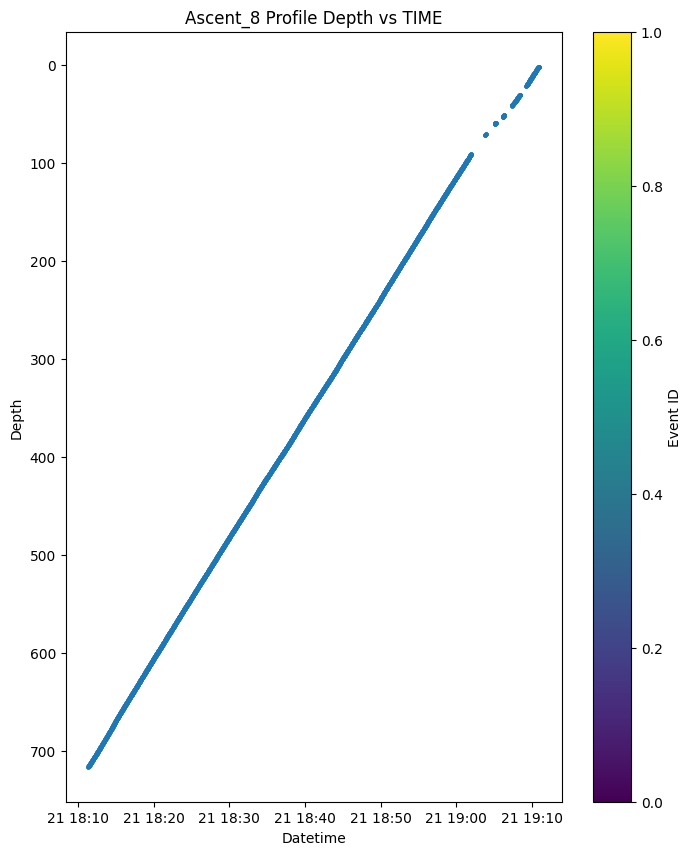

In [21]:
# Filter raw dataset for upcast event_direction
upcast_data = raw.where(raw["event_id"] == "ascent_387", drop=True)

# Map event_id to numeric values
event_id_numeric = pd.factorize(upcast_data["event_id"].to_numpy())[0]

# Plot bbp700 profile
fig, ax = plt.subplots(figsize=(8, 10))
sc = ax.scatter(
    upcast_data["TIME"].to_numpy(),
    upcast_data["DEPTH_SCI"].to_numpy(),
    s=5
)
plt.colorbar(sc, ax=ax, label="Event ID")
ax.set_xlabel("Datetime")
ax.set_ylabel("Depth")
ax.invert_yaxis()
ax.set_title("Ascent_8 Profile Depth vs TIME")

In [66]:
# Compute the ratio
fluo_bbp_ratio = raw["fluo"] / raw["bbp_baseline"]

# Create depth_round variable
depth_round = raw["DEPTH_SCI"].round().astype(int)

# Mask values where sun altitude > 0°
fluo_bbp_ratio = fluo_bbp_ratio.where(raw["sun_altitude"] <= 0)

raw = raw.assign(fluo_bbp_ratio=fluo_bbp_ratio)
# Interpolate NaNs separately for each rounded depth bin
fluo_bbp_ratio_interp = (
    raw["fluo_bbp_ratio"]
    .groupby(depth_round)
    .apply(lambda x: x.interpolate_na(dim="TIME", method="linear"))
)

raw = raw.assign(fluo_bbp_ratio_interp=fluo_bbp_ratio_interp)

In [67]:
# Compute fluo_synthetic
fluo_synthetic = raw['fluo_bbp_ratio_interp'] * raw["bbp_baseline"]

# Compute the condition using element-wise logical operations
condition = ((raw["fluo"] / fluo_synthetic) < 0.9) & (raw["depth"] < 40)
condition2 = (raw['sun_altitude'] > 0) & (raw['depth'] < 40)

# Replace values in fluo where the condition is met
corrected_fluo = raw["fluo"].where(~condition2, fluo_synthetic)

# Create the NPQ column
npq_flag = xr.DataArray(condition2, coords=raw["fluo"].coords)

# Add the corrected fluo and NPQ flag to the dataset
raw = raw.assign(fluo_corrected=corrected_fluo, NPQ=npq_flag)

Text(0.5, 1.0, 'Transect Depth vs Time Showing NPQ')

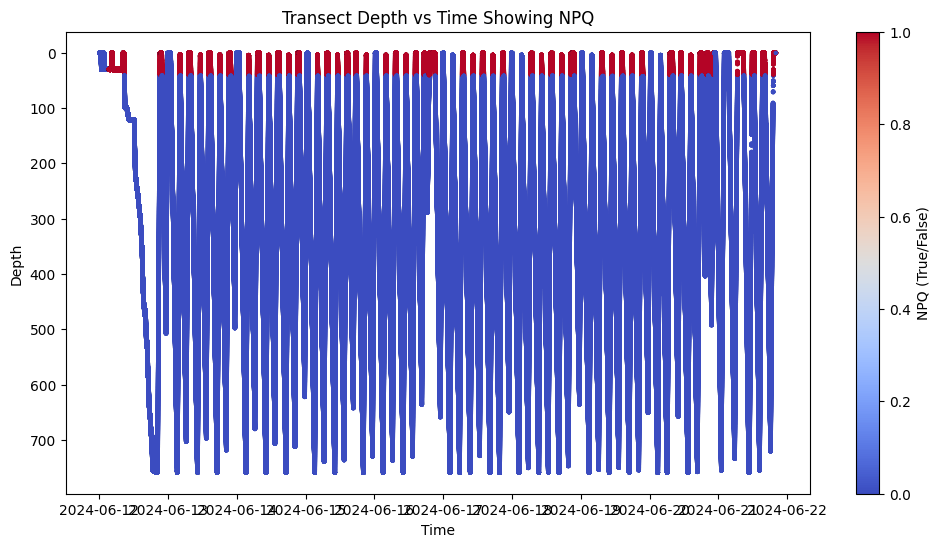

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(
    raw["TIME"].to_numpy(),
    raw["DEPTH_SCI"].to_numpy(),
    c=raw["NPQ"].to_numpy(),
    cmap="coolwarm",
    s=5
)
plt.colorbar(sc, ax=ax, label="NPQ (True/False)")
ax.set_xlabel("Time")
ax.set_ylabel("Depth")
ax.invert_yaxis()
ax.set_title("Transect Depth vs Time Showing NPQ")

Text(0.5, 1.0, 'Chla')

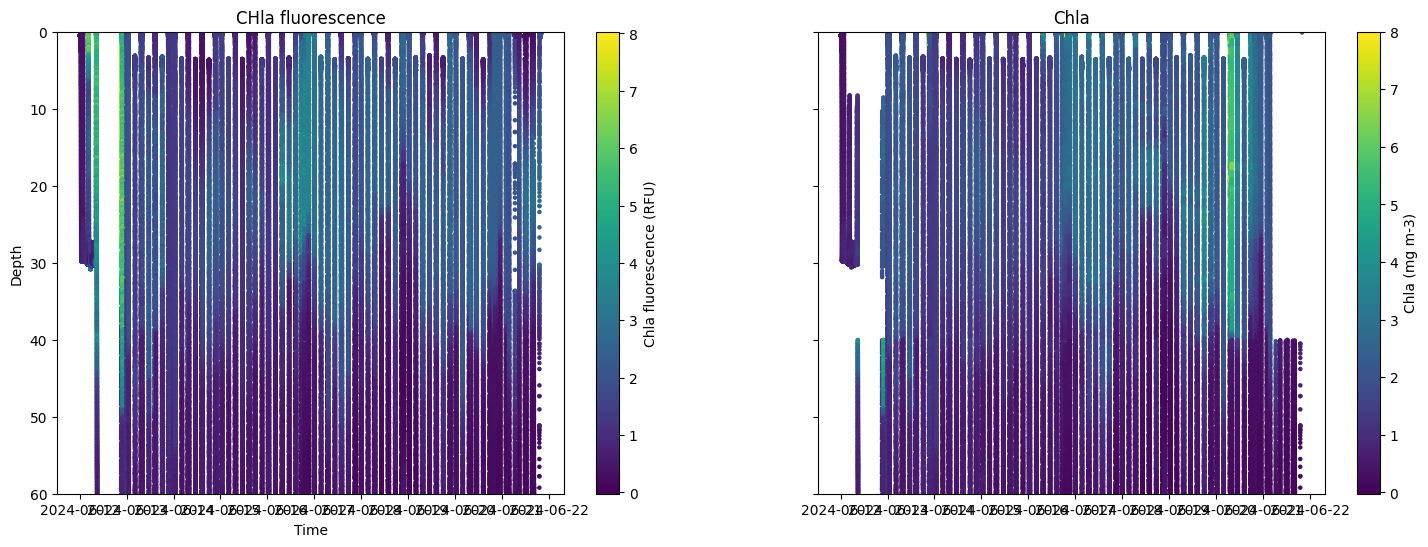

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# First panel: bbp700
sc1 = ax1.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["fluo"].to_numpy(),
    cmap="viridis",
    s=5,
    # Remove ylim from scatter and set it using ax.set_ylim()
    rasterized=True
)
plt.colorbar(sc1, ax=ax1, label="Chla fluorescence (RFU)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Depth")
ax1.invert_yaxis()
ax1.set_title("CHla fluorescence")
ax1.set_ylim(0, 60)  # Set y-axis limits for the first panel
ax1.invert_yaxis()

# Second panel: bbp_baseline
sc2 = ax2.scatter(
    raw["TIME"].to_numpy(),
    raw["depth"].to_numpy(),
    c=raw["fluo_corrected"].to_numpy(),
    cmap="viridis",
    s=5,
    rasterized=True,
    vmax = 8
)
plt.colorbar(sc2, ax=ax2, label="Chla (mg m-3)")
ax2.set_title("Chla")
ax2.set_ylim(0, 60)  # Set y-axis limits for the second panel)
ax2.invert_yaxis()
ax2.set_title("Chla")

In [52]:
unique_ascent_ids = np.unique(raw["event_id"].to_numpy())
print(unique_ascent_ids)

['None_13' 'None_19' 'None_22' 'None_366' 'None_37' 'None_46' 'None_51'
 'None_54' 'None_56' 'None_60' 'None_63' 'None_65' 'None_7' 'None_71'
 'ascent_100' 'ascent_104' 'ascent_109' 'ascent_114' 'ascent_118'
 'ascent_123' 'ascent_127' 'ascent_132' 'ascent_136' 'ascent_14'
 'ascent_141' 'ascent_146' 'ascent_150' 'ascent_155' 'ascent_159'
 'ascent_164' 'ascent_169' 'ascent_173' 'ascent_178' 'ascent_182'
 'ascent_187' 'ascent_191' 'ascent_196' 'ascent_201' 'ascent_210'
 'ascent_215' 'ascent_219' 'ascent_224' 'ascent_228' 'ascent_233'
 'ascent_237' 'ascent_242' 'ascent_247' 'ascent_251' 'ascent_256'
 'ascent_260' 'ascent_265' 'ascent_269' 'ascent_274' 'ascent_279'
 'ascent_283' 'ascent_288' 'ascent_292' 'ascent_299' 'ascent_303'
 'ascent_308' 'ascent_313' 'ascent_317' 'ascent_322' 'ascent_327'
 'ascent_331' 'ascent_336' 'ascent_341' 'ascent_346' 'ascent_355'
 'ascent_368' 'ascent_373' 'ascent_387' 'ascent_61' 'ascent_72'
 'ascent_77' 'ascent_8' 'ascent_82' 'ascent_86' 'ascent_91' 'ascent_9

Text(0.5, 1.0, 'Fluo vs Fluo_corrected Profiles')

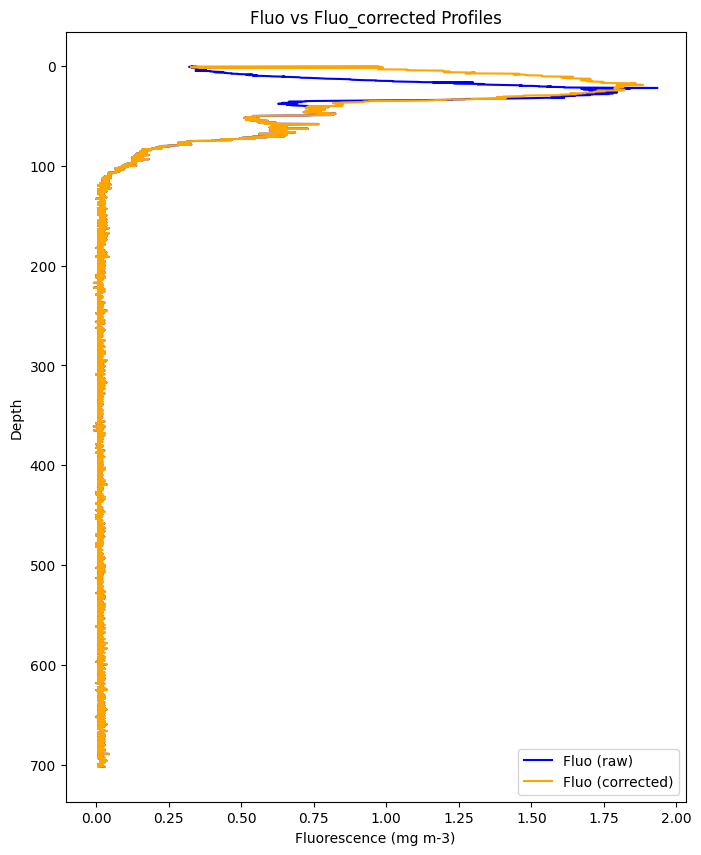

In [62]:
fig, ax = plt.subplots(figsize=(8, 10))
# Filter raw dataset for upcast event_direction
upcast_data = raw.where(raw["event_id"] == "ascent_127", drop=True)
# Plot fluo profile
ax.plot(upcast_data["fluo"], upcast_data["DEPTH_SCI"], label="Fluo (raw)", color="blue")

# Plot fluo_corrected profile
ax.plot(upcast_data["fluo_corrected"], upcast_data["DEPTH_SCI"], label="Fluo (corrected)", color="orange")

# Customize the plot
ax.set_xlabel("Fluorescence (mg m-3)")
ax.set_ylabel("Depth")
ax.invert_yaxis()
ax.legend()
ax.set_title("Fluo vs Fluo_corrected Profiles")

In [70]:
# Add attributes to the Chla variable
raw["fluo_corrected"].attrs["long_name"] = "Corrected Chlorophyll-a Fluorescence"
raw["fluo_corrected"].attrs["units"] = "mg m^-3"
raw["fluo_corrected"].attrs["description"] = "Chlorophyll-a fluorescence corrected for NPQ effects"
raw["fluo_corrected"].attrs["corrections_applied"] = "Dark correction and NPQ correction"

In [72]:
output_file = "../output/ALR6_CTD_with_ecopuk.nc"
raw.to_netcdf(output_file)

print(f"NetCDF file written to {output_file}")

NetCDF file written to ../output/ALR6_CTD_with_ecopuk.nc
